## 載入資料集

In [22]:
import os
import pandas as pd

def create_df_data(folder_path):
    Id = []
    for dirname, _, filenames in os.walk(folder_path):
        for filename in filenames:
            Id.append(os.path.join(dirname, filename))
    
    df_data = pd.DataFrame()
    df_data = df_data.assign(filename=Id)
    df_data['label'] = df_data['filename']
    df_data['label'] = df_data['label'].str.replace(folder_path + '/', '').str.split('_').str[4]
    df_data['target'] = df_data['label'].apply(lambda x: 1 if x == 'anomaly' else 0)
    
    return df_data


train = create_df_data('dataset/2022/bearing/test')
train.head()

,filename,label,target
0,dataset/2022/bearing/test/section_02_target_te...,normal,0
1,dataset/2022/bearing/test/section_01_target_te...,anomaly,1
2,dataset/2022/bearing/test/section_02_target_te...,normal,0
3,dataset/2022/bearing/test/section_00_source_te...,normal,0
4,dataset/2022/bearing/test/section_02_source_te...,anomaly,1


In [23]:
from sklearn.model_selection import train_test_split

# 將資料集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(train, train['target'], test_size=0.05, stratify=train['target'], random_state=42)

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (570, 3)
Testing set shape: (30, 3)


In [24]:
# X_train= pd.concat([X_train, valid], axis=0, ignore_index=True)

## 載入yamnet

In [25]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import scipy

In [26]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [27]:
# import IPython

# for i in range(3):
#     wav_file_name=train['filename'][i]
#     sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
#     sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)
#     waveform = wav_data / tf.int16.max
#     # play
#     IPython.display.display(IPython.display.Audio(wav_data, rate=sample_rate))
#     # Run the model, check the output.
#     scores, embeddings, spectrogram = model(waveform)
#     scores_np = scores.numpy()
#     spectrogram_np = spectrogram.numpy()
#     infered_class = class_names[scores_np.mean(axis=0).argmax()]
#     print(f'pred: [{infered_class} {scores_np.mean(axis=0).argmax()}] true: [{train["label"][i]}]')

In [28]:
import tensorflow as tf
import tensorflow_io as tfio

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

def extract_embedding(wav_data, label):
    ''' Run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))

def create_train_dataset(filenames, targets, batch_size=8, cache=True, shuffle_buffer_size=1000):
    main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
    main_ds = main_ds.map(load_wav_for_map)
    main_ds = main_ds.map(extract_embedding).unbatch()

    if cache:
        main_ds = main_ds.cache()

    main_ds = main_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return main_ds


train_ds = create_train_dataset(X_train['filename'], X_train['target'], batch_size=8, shuffle_buffer_size=250)
test_ds = create_train_dataset(X_test['filename'], X_test['target'], batch_size=8, shuffle_buffer_size=250)

In [29]:
# # 假設你的 train_ds 已經被創建
# train_iterator = train_ds.as_numpy_iterator()

# # 從 iterator 中獲取一個 batch 的數據
# batch_data = next(train_iterator)

# # 從 batch_data 中分別獲取數據和標籤
# data_values = batch_data[0]  # 這裡假設數據在 batch_data 的第一個位置
# labels = batch_data[1]  # 這裡假設標籤在 batch_data 的第二個位置

# # 將 NumPy 陣列轉換為 Python 原生 list，以便更容易查看
# data_values = data_values.tolist()
# labels = labels.tolist()

# # 打印或使用數據和標籤
# print("Data values:", data_values)
# print("Labels:", labels)

## 建立遷移模型

In [30]:
tf.keras.backend.clear_session() # 清空網路暫存
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525826 (2.01 MB)
Trainable params: 525826 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [32]:
history = my_model.fit(train_ds,
                       epochs=20,
                       callbacks=callback)

Epoch 1/20
1425/1425 [==============================] - 38s 25ms/step - loss: 0.5198 - accuracy: 0.7384
Epoch 2/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.3856 - accuracy: 0.8240
Epoch 3/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.3321 - accuracy: 0.8532
Epoch 4/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.2920 - accuracy: 0.8744
Epoch 5/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.2597 - accuracy: 0.8907
Epoch 6/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.2366 - accuracy: 0.9011
Epoch 7/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.2208 - accuracy: 0.9100
Epoch 8/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.1999 - accuracy: 0.9172
Epoch 9/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.1836 - accuracy: 0.9277
Epoch 10/20
1425/1425 [==============================] - 3s 2ms/step - loss: 0.1

In [33]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

75/75 [==============================] - 2s 16ms/step - loss: 1.1989 - accuracy: 0.7117
Loss:  1.1989048719406128
Accuracy:  0.7116666436195374


## 測試模型

In [34]:
my_classes = ['normal', 'anomaly']

In [35]:
index=39
testing_wav_data = load_wav_16k_mono(train['filename'][index])
scores, embeddings, spectrogram = model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'pred: [{inferred_class} {scores.numpy().mean(axis=0).argmax()}] true: [{train["label"][index]}]')

pred: [normal 510] true: [normal]


In [36]:
y_pred=[]
error_list=[]
for i in range(len(X_test.index)):
    index= X_test.index[i]
    testing_wav_data = load_wav_16k_mono(train['filename'][index])
    scores, embeddings, spectrogram = model(testing_wav_data)
    result = my_model(embeddings).numpy()
    y_pred.append(result.mean(axis=0).argmax())
    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'pred: [{inferred_class} {scores.numpy().mean(axis=0).argmax()}] true: [{train["label"][index]}]')
    if y_pred[i]!=train["target"][index]:
        error_list.append(index)
error_list = np.array(error_list)

pred: [normal 510] true: [anomaly]


pred: [normal 514] true: [normal]


pred: [anomaly 514] true: [anomaly]
pred: [normal 510] true: [normal]


pred: [normal 398] true: [normal]


pred: [normal 510] true: [normal]


pred: [anomaly 490] true: [anomaly]


pred: [normal 507] true: [normal]


pred: [normal 507] true: [normal]


pred: [normal 514] true: [anomaly]


pred: [normal 510] true: [anomaly]


pred: [normal 490] true: [normal]


pred: [normal 490] true: [normal]


pred: [normal 510] true: [normal]


pred: [normal 514] true: [anomaly]


pred: [normal 494] true: [anomaly]


pred: [anomaly 510] true: [anomaly]


pred: [anomaly 510] true: [anomaly]


pred: [anomaly 376] true: [anomaly]


pred: [anomaly 507] true: [normal]


pred: [normal 510] true: [normal]


pred: [normal 510] true: [normal]


pred: [normal 490] true: [normal]


pred: [anomaly 507] true: [anomaly]


pred: [normal 514] true: [normal]


pred: [normal 494] true: [normal]


pred: [anomaly 490] true: [anomaly]


pred: [normal 514] true: [anomaly]


pred: [normal 514] true: [anomaly]


pred: [anomaly 510] true: [anomaly]


In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30

Accuracy: 0.7333333333333333


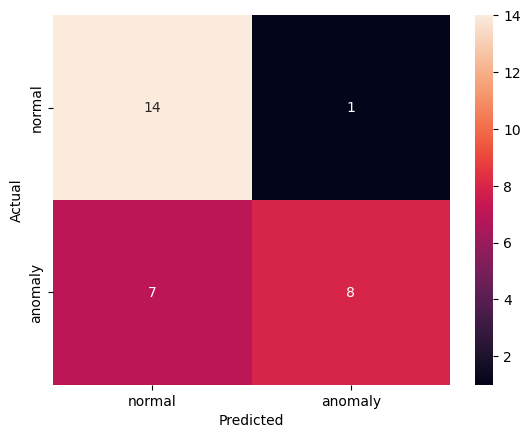

In [38]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(actual_val, pred_val, labels, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    plt.show()
plot_confusion_matrix(y_test, y_pred, labels=my_classes)

In [39]:
import IPython

for index in error_list:
    wav_file_name = train['filename'][index]
    testing_wav_data = load_wav_16k_mono(wav_file_name)
    # play Audio
    IPython.display.display(IPython.display.Audio(testing_wav_data, rate=16000))
    scores, embeddings, spectrogram = model(testing_wav_data)
    result = my_model(embeddings).numpy()
    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'finename:{wav_file_name} pred: [{inferred_class} {result.mean(axis=0)} {scores.numpy().mean(axis=0).argmax()}] true: [{train["label"][index]}]')

finename:dataset/2022/bearing/test/section_01_target_test_anomaly_0029_vel_12_loc_H.wav pred: [normal [0.7612828  0.23871723] 510] true: [anomaly]


finename:dataset/2022/bearing/test/section_01_target_test_anomaly_0006_vel_12_loc_F.wav pred: [normal [0.87528056 0.12471938] 514] true: [anomaly]


finename:dataset/2022/bearing/test/section_02_source_test_anomaly_0010_vel_14_f-n_B.wav pred: [normal [0.73662126 0.26337883] 510] true: [anomaly]


finename:dataset/2022/bearing/test/section_01_target_test_anomaly_0043_vel_4_loc_F.wav pred: [normal [0.61927146 0.3807285 ] 514] true: [anomaly]


finename:dataset/2022/bearing/test/section_01_source_test_anomaly_0033_vel_12_loc_A.wav pred: [normal [0.8244774  0.17552254] 494] true: [anomaly]


finename:dataset/2022/bearing/test/section_00_target_test_normal_0024_vel_8.wav pred: [anomaly [0.3273298  0.67267025] 507] true: [normal]


finename:dataset/2022/bearing/test/section_01_source_test_anomaly_0009_vel_12_loc_C.wav pred: [normal [0.64631397 0.35368595] 514] true: [anomaly]


finename:dataset/2022/bearing/test/section_02_source_test_anomaly_0018_vel_6_f-n_B.wav pred: [normal [0.9177219  0.08227811] 514] true: [anomaly]


## 對2023的資料集驗證

In [40]:
valid = create_df_data('dataset/2023/bearing/test')
valid.head()

,filename,label,target
0,dataset/2023/bearing/test/section_00_target_te...,normal,0
1,dataset/2023/bearing/test/section_00_source_te...,anomaly,1
2,dataset/2023/bearing/test/section_00_source_te...,anomaly,1
3,dataset/2023/bearing/test/section_00_source_te...,anomaly,1
4,dataset/2023/bearing/test/section_00_target_te...,anomaly,1


In [41]:
y_pred=[]
error_list=[]
for i in range(200):
    index= i
    testing_wav_data = load_wav_16k_mono(valid['filename'][index])
    # play Audio
    # IPython.display.display(IPython.display.Audio(testing_wav_data, rate=sample_rate))
    scores, embeddings, spectrogram = model(testing_wav_data)
    result = my_model(embeddings).numpy()
    y_pred.append(result.mean(axis=0).argmax())
    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'filename: {valid["filename"][index]} pred: [{inferred_class} {scores.numpy().mean(axis=0).argmax()}] true: [{valid["label"][index]}]')
    if y_pred[i]!=valid["target"][index]:
        error_list.append(index)
error_list = np.array(error_list)

filename: dataset/2023/bearing/test/section_00_target_test_normal_0019_vel_8_loc_G.wav pred: [anomaly 481] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0022_vel_13_loc_A.wav pred: [anomaly 376] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0048_vel_17_loc_A.wav pred: [anomaly 298] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0026_vel_8_loc_B.wav pred: [normal 132] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0001_vel_8_loc_G.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0042_vel_13_loc_A.wav pred: [normal 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0028_vel_17_loc_A.wav pred: [anomaly 329] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0033_vel_8_loc_A.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0024_vel_5_loc_A.wav pred: [normal 132] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0008_vel_16_loc_A.wav pred: [anomaly 409] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0004_vel_8_loc_F.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0039_vel_16_loc_F.wav pred: [normal 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0035_vel_13_loc_A.wav pred: [anomaly 329] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0030_vel_16_loc_D.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0032_vel_17_loc_A.wav pred: [anomaly 298] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0009_vel_25_loc_A.wav pred: [anomaly 294] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0038_vel_8_loc_A.wav pred: [anomaly 481] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0003_vel_9_loc_A.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0019_vel_16_loc_D.wav pred: [normal 507] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0011_vel_16_loc_H.wav pred: [anomaly 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0039_vel_8_loc_B.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0040_vel_8_loc_D.wav pred: [normal 132] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0028_vel_21_loc_A.wav pred: [normal 333] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0038_vel_8_loc_D.wav pred: [normal 382] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0010_vel_16_loc_A.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0017_vel_25_loc_A.wav pred: [anomaly 412] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0019_vel_13_loc_A.wav pred: [anomaly 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0014_vel_8_loc_D.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0015_vel_5_loc_A.wav pred: [normal 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0030_vel_1_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0028_vel_8_loc_H.wav pred: [normal 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0003_vel_8_loc_C.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0039_vel_16_loc_C.wav pred: [normal 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0036_vel_16_loc_D.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0025_vel_5_loc_A.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0017_vel_17_loc_A.wav pred: [anomaly 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0049_vel_25_loc_A.wav pred: [anomaly 132] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0026_vel_16_loc_B.wav pred: [anomaly 490] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0025_vel_11_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0004_vel_16_loc_D.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0049_vel_13_loc_A.wav pred: [normal 376] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0005_vel_5_loc_A.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0047_vel_5_loc_A.wav pred: [normal 132] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0013_vel_16_loc_G.wav pred: [normal 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0040_vel_16_loc_H.wav pred: [normal 409] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0010_vel_16_loc_H.wav pred: [normal 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0018_vel_16_loc_F.wav pred: [anomaly 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0001_vel_8_loc_F.wav pred: [anomaly 481] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0047_vel_3_loc_A.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0021_vel_16_loc_B.wav pred: [anomaly 199] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0031_vel_25_loc_A.wav pred: [anomaly 294] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0012_vel_9_loc_A.wav pred: [normal 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0020_vel_7_loc_A.wav pred: [normal 200] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0008_vel_23_loc_A.wav pred: [normal 510] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0021_vel_16_loc_A.wav pred: [anomaly 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0022_vel_9_loc_A.wav pred: [anomaly 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0033_vel_11_loc_A.wav pred: [anomaly 376] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0024_vel_8_loc_A.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0045_vel_16_loc_C.wav pred: [anomaly 362] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0048_vel_8_loc_E.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0017_vel_8_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0016_vel_21_loc_A.wav pred: [normal 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0046_vel_8_loc_F.wav pred: [normal 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0048_vel_8_loc_H.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0012_vel_3_loc_A.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0027_vel_19_loc_A.wav pred: [anomaly 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0044_vel_5_loc_A.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0032_vel_23_loc_A.wav pred: [anomaly 490] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0015_vel_9_loc_A.wav pred: [anomaly 409] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0030_vel_21_loc_A.wav pred: [anomaly 510] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0002_vel_16_loc_H.wav pred: [normal 409] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0000_vel_16_loc_D.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0011_vel_13_loc_A.wav pred: [anomaly 376] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0014_vel_11_loc_A.wav pred: [anomaly 376] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0006_vel_23_loc_A.wav pred: [anomaly 412] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0048_vel_16_loc_D.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0042_vel_9_loc_A.wav pred: [anomaly 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0031_vel_21_loc_A.wav pred: [normal 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0049_vel_17_loc_A.wav pred: [normal 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0013_vel_5_loc_A.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0029_vel_16_loc_C.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0026_vel_3_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0040_vel_16_loc_H.wav pred: [normal 329] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0041_vel_8_loc_E.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0037_vel_8_loc_C.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0044_vel_8_loc_H.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0031_vel_8_loc_C.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0000_vel_8_loc_E.wav pred: [normal 406] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0000_vel_8_loc_E.wav pred: [anomaly 481] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0040_vel_16_loc_B.wav pred: [anomaly 362] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0029_vel_16_loc_B.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0014_vel_7_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0041_vel_21_loc_A.wav pred: [anomaly 513] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0041_vel_8_loc_F.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0038_vel_1_loc_A.wav pred: [anomaly 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0017_vel_16_loc_G.wav pred: [anomaly 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0026_vel_16_loc_E.wav pred: [anomaly 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0029_vel_23_loc_A.wav pred: [anomaly 507] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0036_vel_3_loc_A.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0018_vel_7_loc_A.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0037_vel_25_loc_A.wav pred: [anomaly 510] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0009_vel_8_loc_C.wav pred: [normal 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0008_vel_16_loc_H.wav pred: [anomaly 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0043_vel_1_loc_A.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0046_vel_16_loc_E.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0027_vel_15_loc_A.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0009_vel_19_loc_A.wav pred: [normal 294] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0043_vel_16_loc_D.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0020_vel_21_loc_A.wav pred: [normal 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0023_vel_16_loc_H.wav pred: [normal 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0036_vel_25_loc_A.wav pred: [anomaly 294] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0007_vel_21_loc_A.wav pred: [anomaly 513] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0041_vel_16_loc_C.wav pred: [anomaly 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0020_vel_16_loc_D.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0019_vel_15_loc_A.wav pred: [anomaly 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0038_vel_8_loc_F.wav pred: [anomaly 333] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0012_vel_8_loc_B.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0020_vel_19_loc_A.wav pred: [anomaly 510] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0001_vel_8_loc_C.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0022_vel_25_loc_A.wav pred: [normal 510] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0047_vel_21_loc_A.wav pred: [normal 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0012_vel_8_loc_G.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0033_vel_3_loc_A.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0002_vel_13_loc_A.wav pred: [anomaly 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0004_vel_11_loc_A.wav pred: [anomaly 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0018_vel_9_loc_A.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0009_vel_9_loc_A.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0021_vel_16_loc_F.wav pred: [anomaly 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0011_vel_16_loc_E.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0023_vel_16_loc_E.wav pred: [anomaly 362] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0013_vel_8_loc_G.wav pred: [anomaly 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0003_vel_16_loc_H.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0034_vel_16_loc_G.wav pred: [anomaly 490] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0023_vel_17_loc_A.wav pred: [normal 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0000_vel_16_loc_A.wav pred: [normal 410] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0006_vel_8_loc_F.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0034_vel_16_loc_B.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0003_vel_25_loc_A.wav pred: [anomaly 475] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0039_vel_1_loc_A.wav pred: [normal 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0016_vel_16_loc_E.wav pred: [normal 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0043_vel_23_loc_A.wav pred: [anomaly 507] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0035_vel_15_loc_A.wav pred: [anomaly 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0034_vel_16_loc_A.wav pred: [normal 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0035_vel_16_loc_D.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0025_vel_16_loc_C.wav pred: [anomaly 199] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0024_vel_1_loc_A.wav pred: [normal 382] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0006_vel_17_loc_A.wav pred: [anomaly 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0005_vel_8_loc_G.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0024_vel_15_loc_A.wav pred: [normal 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0037_vel_8_loc_H.wav pred: [anomaly 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0022_vel_19_loc_A.wav pred: [anomaly 294] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0035_vel_7_loc_A.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0032_vel_11_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0045_vel_8_loc_F.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0016_vel_8_loc_D.wav pred: [anomaly 481] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0034_vel_3_loc_A.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0031_vel_8_loc_F.wav pred: [normal 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0005_vel_8_loc_E.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0049_vel_16_loc_F.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0030_vel_23_loc_A.wav pred: [anomaly 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0037_vel_16_loc_B.wav pred: [normal 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0004_vel_5_loc_A.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0018_vel_16_loc_A.wav pred: [normal 398] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0015_vel_16_loc_G.wav pred: [anomaly 407] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0027_vel_9_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0028_vel_11_loc_A.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0008_vel_17_loc_A.wav pred: [anomaly 329] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0023_vel_16_loc_C.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0042_vel_15_loc_A.wav pred: [anomaly 294] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0032_vel_21_loc_A.wav pred: [normal 507] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0013_vel_8_loc_A.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0046_vel_16_loc_B.wav pred: [normal 490] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0007_vel_8_loc_G.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0042_vel_16_loc_E.wav pred: [normal 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0002_vel_13_loc_A.wav pred: [anomaly 376] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0010_vel_8_loc_E.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0015_vel_8_loc_G.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0016_vel_7_loc_A.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0036_vel_9_loc_A.wav pred: [normal 376] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0043_vel_16_loc_A.wav pred: [anomaly 199] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0047_vel_1_loc_A.wav pred: [anomaly 500] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0005_vel_17_loc_A.wav pred: [anomaly 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0046_vel_21_loc_A.wav pred: [anomaly 513] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0011_vel_13_loc_A.wav pred: [normal 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0025_vel_19_loc_A.wav pred: [normal 294] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0029_vel_19_loc_A.wav pred: [normal 294] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0021_vel_8_loc_G.wav pred: [normal 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_anomaly_0007_vel_16_loc_H.wav pred: [anomaly 398] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0045_vel_7_loc_A.wav pred: [anomaly 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0033_vel_8_loc_B.wav pred: [anomaly 406] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0044_vel_5_loc_A.wav pred: [anomaly 132] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0044_vel_16_loc_H.wav pred: [normal 329] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0010_vel_8_loc_D.wav pred: [normal 514] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0014_vel_17_loc_A.wav pred: [anomaly 490] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0006_vel_5_loc_A.wav pred: [anomaly 514] true: [anomaly]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0007_vel_16_loc_B.wav pred: [anomaly 409] true: [normal]


filename: dataset/2023/bearing/test/section_00_target_test_normal_0002_vel_15_loc_A.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0001_vel_9_loc_A.wav pred: [anomaly 500] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_normal_0027_vel_13_loc_A.wav pred: [anomaly 132] true: [normal]


filename: dataset/2023/bearing/test/section_00_source_test_anomaly_0045_vel_8_loc_C.wav pred: [normal 132] true: [anomaly]


In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(valid['target'].values, y_pred))
print("Accuracy:", accuracy_score(valid['target'].values, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.47      0.51       100
           1       0.55      0.64      0.59       100

    accuracy                           0.56       200
   macro avg       0.56      0.55      0.55       200
weighted avg       0.56      0.56      0.55       200

Accuracy: 0.555


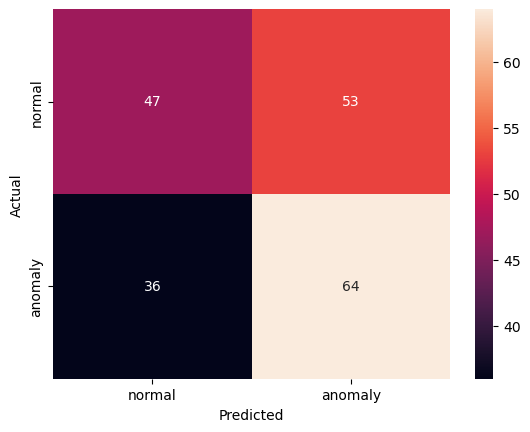

In [43]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(actual_val, pred_val, labels, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    plt.show()
plot_confusion_matrix(valid['target'].values, y_pred, labels=my_classes)